In [1]:
from FNFTpy import nsev
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import pandas as pd
from timeit import default_timer as timer
from tqdm import tqdm

import numpy as np
import random
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.integrate import simps
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

import signal_generation as sg
from importlib import reload
reload(sg)
from ssfm import fiber_propogate

import nft_analyse as nft
reload(nft)

import scipy.io


# Main section
## Create signal

In [9]:
print(sg.dispersion_to_beta2(16.8))
print()


-21.4127060435836


In [198]:
for p_dbm in [-20, -10, -5] + [-5 + i_temp * (0 - (-5)) / 10 for i_temp in range(1, 10)] + [0, 1, 3]:
    print(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6), p_dbm)

print(sg.mw_to_dbm(sg.nd_to_mw(0.01, t_symb=14.8)))

0.000129 -20
0.001294 -10
0.004092 -5
0.004591 -4.5
0.005151 -4.0
0.005779 -3.5
0.006485 -3.0
0.007276 -2.5
0.008164 -2.0
0.00916 -1.5
0.010278 -1.0
0.011532 -0.5
0.012939 0
0.016289 1
0.025816 3
-1.1188869183026635


In [2]:
# create signal

mod_type = "16qam"
n_car = 1
t_symb = 1.0
n_symb = 4
dt = t_symb / n_symb
num_symbols = 2 ** 13
n_lateral = 32 * n_symb
# p_ave = 0.74
p_ave = 0.05
roll_off = 0.01

In [3]:
data = sg.gen_wdm_bit_sequence(num_symbols, mod_type, n_car)
points = sg.get_constellation_point(data, mod_type)
signal = sg.get_wdm_signal(data, t_symb=t_symb, n_symb=n_symb,
                        func=sg.srrcos, func_args=[t_symb, roll_off],
                        n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
signal = sg.set_average_power(signal, dt, p_ave, n_symb * (num_symbols // 2 - 1))
# print(len(signal), sg.next_power_of_2(len(signal)))
# signal = sg.add_lateral(signal, 2**13 - len(signal) // 2)
n_add = sg.next_power_of_2(len(signal)) - len(signal) // 2
signal = sg.add_lateral(signal, n_add)

# signal = sg.add_lateral(signal, 2**10)

np_signal = len(signal)
t_vector = np.array([(i - np_signal / 2) * dt for i in range(np_signal)])

# so now signal if a full signal

## Function to get sub intervals

In [4]:
# slope for boundaries interpolation
def slope(x):
    if np.absolute(x) > 0:
        return np.exp(-np.power(0.01 * x, 2))
        # return 0.0
    else:
        return 0.0

def slope_t(t):
    return t

def get_process_interval(signal, n_symb, t_proc, skip=0):

    end_point = int(t_proc * n_symb)
    # print(end_point)
    return signal[skip:skip + end_point]

def get_sub_signal(signal, n_symb, t_symb, num_symb_proc, num_symb_skip, n_shift):

    t_proc = num_symb_proc * t_symb
    signal_cut = get_process_interval(signal, n_symb, t_proc, skip=n_shift + num_symb_skip * n_symb)
    np_signal = len(signal)
    dt = t_symb / n_symb
    t_vector = np.array([(i - np_signal / 2) * dt for i in range(np_signal)])
    t_cut = get_process_interval(t_vector, n_symb, t_proc, skip=n_shift + num_symb_skip * n_symb)

    return signal_cut, t_cut

def add_lateral_to_signal(signal, f_slope, t):

    dt = t[1] - t[0]
    n_add = sg.next_power_of_2(len(signal)) - len(signal) // 2
    signal_new = sg.add_lateral_function(signal, f_slope, dt, n = n_add)

    t_add = np.array([i * dt for i in range(n_add)])
    t_new = np.concatenate((t_add - t_add[-1] + t[0], t, t_add + t[-1]), axis=None)

    return signal_new, t_new

# t_proc = 64 * t_symb # 64 symbols to process
# num_symb_skip = 32
# signal_cut = get_process_interval(signal, n_symb, t_proc, skip=n_add + n_lateral + num_symb_skip * n_symb)
# t_cut = get_process_interval(t_vector, n_symb, t_proc, skip=n_add + n_lateral + num_symb_skip * n_symb)
#
# print(len(signal_cut), len(t_cut))
# print(len(signal), len(t_vector))
#
#
#
# n_add_cut = sg.next_power_of_2(len(signal_cut)) - len(signal_cut) // 2
# signal_cut = sg.add_lateral_function(signal_cut, slope, dt, n = n_add_cut)
#
# # t_cut_add = np.array([(i - len(signal_cut) / 2) * dt for i in range(len(signal_cut))])
# # t_cut_add = sg.add_lateral_function(t_cut, slope_t, dt, n = n_add_cut)
# t_add_temp = np.array([i * dt for i in range(n_add_cut)])
# t_cut_add = np.concatenate((t_add_temp - t_add_temp[-1] + t_cut[0], t_cut, t_add_temp + t_cut[-1]), axis=None)

In [5]:
num_symb_proc = 256 + 32
num_symb_skip = 256
signal_cut, t_cut = get_sub_signal(signal, n_symb, t_symb, num_symb_proc, num_symb_skip, n_add + n_lateral)
# signal_cut, t_cut = add_lateral_to_signal(signal_cut, slope, t_cut)

### Draw pictures
Check that everything works

<ipython-input-7-308264bc95ac>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


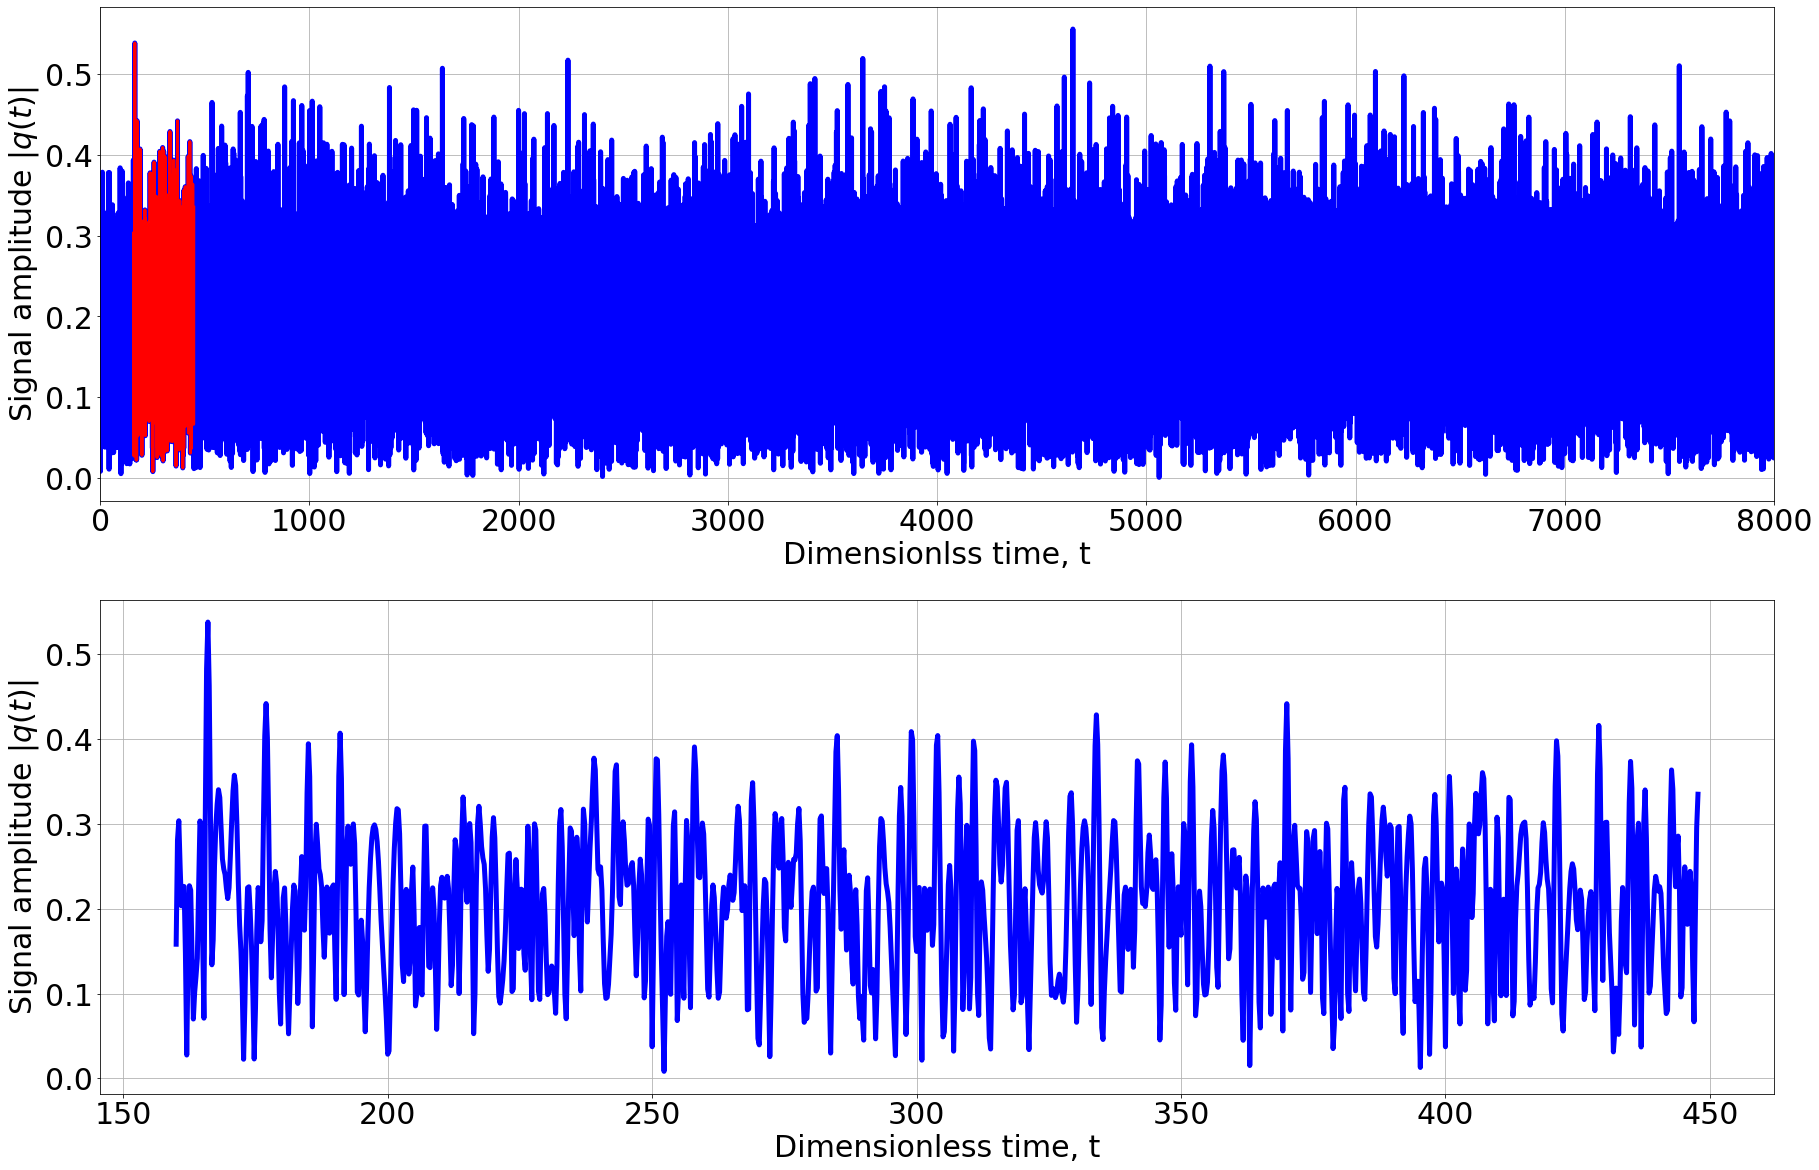

In [7]:
# draw signal and processing interval

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(30, 20))
axs[0].plot(t_vector + 4000, np.absolute(signal),
            color='blue', linewidth=5.0)
axs[0].plot(t_cut + 4000, np.absolute(signal_cut),
            color='red', linewidth=3.0)
axs[0].set_xlim(0, 8000)
axs[0].set_xlabel('Dimensionlss time, t')
axs[0].set_ylabel('Signal amplitude $|q(t)|$')
axs[0].grid(True)

axs[1].plot(t_cut + 4000, np.absolute(signal_cut),
            color='blue', linewidth=5.0)
# axs[1].plot(t_vector, np.absolute(signal) - np.absolute(signal_bprop_nft),
#             color='red', linewidth=3.0)
# axs[1].set_xlim(-20, 20)
axs[1].set_xlabel('Dimensionless time, t')
axs[1].set_ylabel('Signal amplitude $|q(t)|$')
# axs[1].set_yscale('log')
axs[1].grid(True)

fig.show()
fig.savefig('../images/signal_process/signal_process_example.pdf', format='pdf', bbox_inches='tight')

## Calculate NF spectrum

In [108]:
def do_nft(signal, t):

    np_signal = len(signal)
    np_spectrum = 2 * np_signal

    # calculate suitable frequency bonds (xi)
    rv, xi_bound = nsev_inverse_xi_wrapper(np_signal, t[0], t[-1], np_spectrum)
    xi_vector = xi_bound[0] + np.arange(np_spectrum) * (xi_bound[1] - xi_bound[0]) / (np_spectrum - 1)

    start = timer()
    res = nsev(signal, t, M=np_spectrum, Xi1=xi_bound[0], Xi2=xi_bound[1], K=1024, kappa=1, cst=2, dst=0, dis=2)
    end = timer()

    # cont_spec = res['cont_ref']
    # bound_states = res['bound_states']
    # disc_norm = res['disc_norm']

    return xi_vector, res, (end - start)

In [6]:
num_symb_proc = 32
num_symb_skip_shift = 32 # some initial shift from left side
step = num_symb_proc

num_symb_d_max = 128

# we have 2**14 symbols
# (2**14 - 2 * num_symb_skip_shift - 2 * num_symb_d_max) / step
proc_steps = (num_symbols - 2 * num_symb_skip_shift - 2 * num_symb_d_max) // step

temp_r = [i for i in range(proc_steps)]


In [ ]:
df = pd.DataFrame()

for proc_iter in range(proc_steps):
# for proc_iter in [temp_r[0], temp_r[1]]:

    # to do three intervals I have to take
    for num_symb_d in [0, num_symb_d_max // 2, num_symb_d_max]:
    # for num_symb_d in [0]:
        # num_symb_d = 256
        num_symb_total = 2 * num_symb_d + num_symb_proc

        num_symb_skip_base = num_symb_d + num_symb_skip_shift # desire skip to the proc interval. Have to be bigger that num_symb_d
        num_symb_skip = num_symb_skip_base - num_symb_d + proc_iter * step

        signal_cut, t_cut = get_sub_signal(signal, n_symb, t_symb, num_symb_total, num_symb_skip, n_add + n_lateral)

        ft_spectrum = fftshift(fft(signal_cut))
        ft_w = np.array([(i - len(signal_cut) / 2) * (2. * np.pi / len(signal_cut)) for i in range(len(signal_cut))])

        signal_cut, t_cut = add_lateral_to_signal(signal_cut, slope, t_cut)
        # print(len(signal_cut))

        xi, res, time = do_nft(signal_cut, t_cut)
        print("n sol", num_symb_d, len(res['bound_states']))
        dxi = xi[1] - xi[0]

        l1_norm = sg.get_l1(signal_cut, dt)
        l2_norm = sg.get_energy(signal_cut, dt)
        e_discrete = 4 * np.sum(np.imag(res['bound_states']))
        e_cont = -1. / np.pi * np.sum(np.log(np.power(np.absolute(res['cont_a']), 2))) * dxi



        result_dict = {"signal": signal_cut, "t": t_cut, "res": res, "xi": xi,
                       "l1_norm": l1_norm, "l2_norm": l2_norm,
                       "e_discrete": e_discrete, "e_cont": e_cont,
                       "e_tot": e_discrete + e_cont,
                       "time": time,
                       'proc_steps': proc_steps,
                       "proc_iter": proc_iter,
                       'num_symbols': num_symbols,
                       'n_symb': n_symb,
                       't_symb': t_symb,
                       'n_lateral': n_lateral,
                       'p_ave': p_ave,
                       'roll_off': roll_off,
                       'mod_type': mod_type,
                       'n_car': n_car,
                       'num_symb_d': num_symb_d,
                       'num_symb_skip_base': num_symb_skip_base,
                       'num_symb_skip': num_symb_skip,
                       'num_symb_d_max': num_symb_d_max,
                       'num_symb_proc': num_symb_proc,
                       'num_symb_skip_shift': num_symb_skip_shift,
                       'step': step}

        print(np.absolute(e_discrete + e_cont - l2_norm), l2_norm, np.absolute(e_discrete + e_cont - l2_norm) / l2_norm)

        df = df.append(result_dict, ignore_index=True)
        # df.to_pickle("nft_continuous_signal_scan.pkl")

        # res_bprop = nsev_inverse(xi, t_cut, res['cont_ref'], res['bound_states'], res['disc_norm'], cst=0, dst=0)
        # print(np.mean(np.absolute(res_bprop["q"] - signal_cut)))
        #
        # matplotlib.rcParams.update({'font.size': 30})
        #
        # fig, axs = plt.subplots(2, 1, figsize=(15, 15))
        # axs[0].plot(t_cut, np.absolute(signal_cut),
        #             color='blue', linewidth=5.0)
        # axs[0].plot(t_cut, np.absolute(res_bprop["q"]),
        #             color='red', linewidth=3.0)
        # # axs[0].set_xlim(-30, 30)
        # axs[0].set_xlabel('T')
        # axs[0].set_ylabel('Abs')
        # axs[0].grid(True)
        #
        # axs[1].plot(xi, np.absolute(res['cont_ref']),
        #             color='blue', linewidth=5.0)
        # # axs[1].plot(t_vector, np.absolute(signal) - np.absolute(signal_bprop_nft),
        # #             color='red', linewidth=3.0)
        # # axs[1].set_xlim(-20, 20)
        # axs[1].set_xlabel('T')
        # axs[1].set_ylabel('Abs prop')
        # # axs[1].set_yscale('log')
        # axs[1].grid(True)
        #
        # fig.show()

df.to_pickle("nft_continuous_signal_scan_p_0.05.pkl")

## Plot 2d maps

In [39]:
current_dbm = -4

# df_plot = pd.read_pickle("nft_continuous_signal_scan.pkl")
df_plot = pd.read_pickle("nft_real_signal_spectogram_" + str(current_dbm) + "dbm.pkl")


### Plot reflection coefficient

In [4]:
print(df_plot[(df_plot.num_symb_d == 0)]['proc_steps'].to_list()[0])

300.0


In [40]:
# print(df_plot['res'][0]['cont_ref'])
# print(df_plot['xi'][0])
# print(xi)

# print(num_symb_d_max // 2)
# print(df_plot[(df_plot.num_symb_d == 128)]['xi'].to_list()[0])
xi_0 = df_plot[(df_plot.num_symb_d == 0)]['xi'].to_list()[0]
xi_64 = df_plot[(df_plot.num_symb_d == 64.0)]['xi'].to_list()[0]
xi_128 = df_plot[(df_plot.num_symb_d == 128.0)]['xi'].to_list()[0]

proc_steps_0 = int(df_plot[(df_plot.num_symb_d == 0)]['proc_steps'].to_list()[0])
proc_steps_64 = int(df_plot[(df_plot.num_symb_d == 64.0)]['proc_steps'].to_list()[0])
proc_steps_128 = int(df_plot[(df_plot.num_symb_d == 128.0)]['proc_steps'].to_list()[0])

y_0, x_0 = np.meshgrid(xi_0, np.array(range(proc_steps_0)))
y_64, x_64 = np.meshgrid(xi_64, np.array(range(proc_steps_64)))
y_128, x_128 = np.meshgrid(xi_128, np.array(range(proc_steps_128)))

z_0 = np.absolute(np.array([d.get('cont_ref') for d in df_plot[(df_plot.num_symb_d == 0)]['res']]))
z_64 = np.absolute(np.array([d.get('cont_ref') for d in df_plot[(df_plot.num_symb_d == 64)]['res']]))
z_128 = np.absolute(np.array([d.get('cont_ref') for d in df_plot[(df_plot.num_symb_d == 128)]['res']]))

# z_max_0 = np.max(z_0)

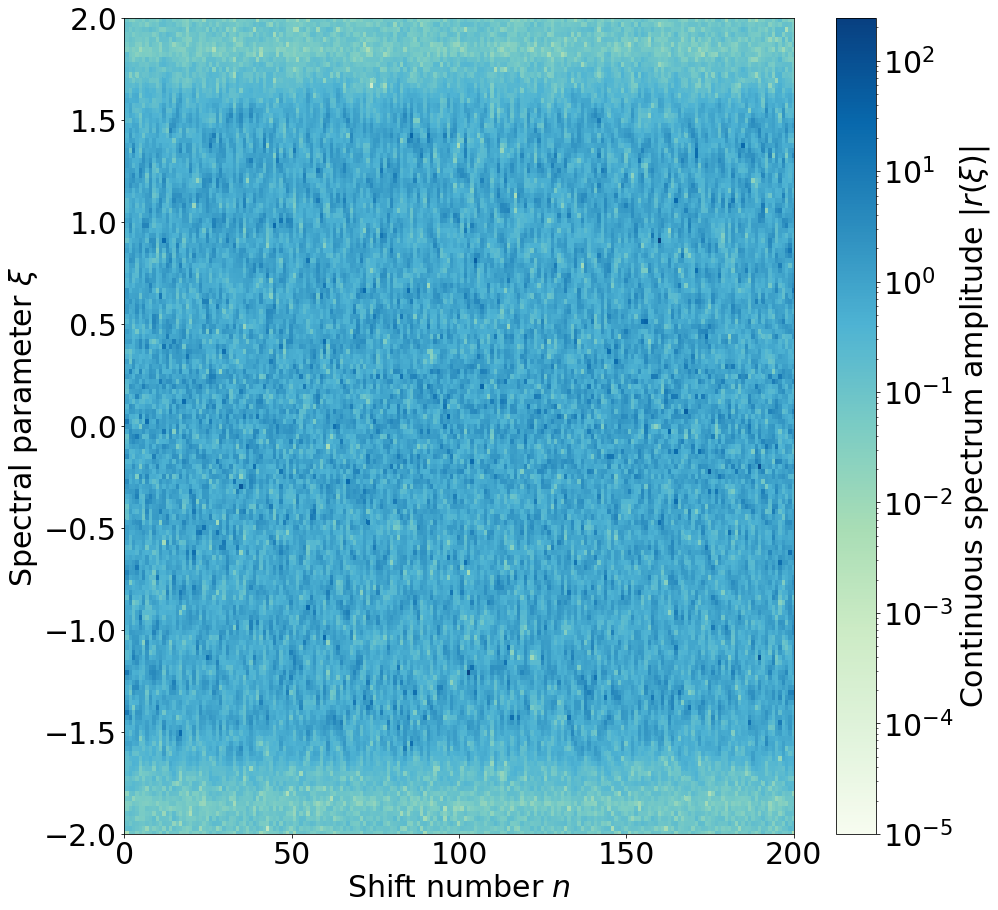

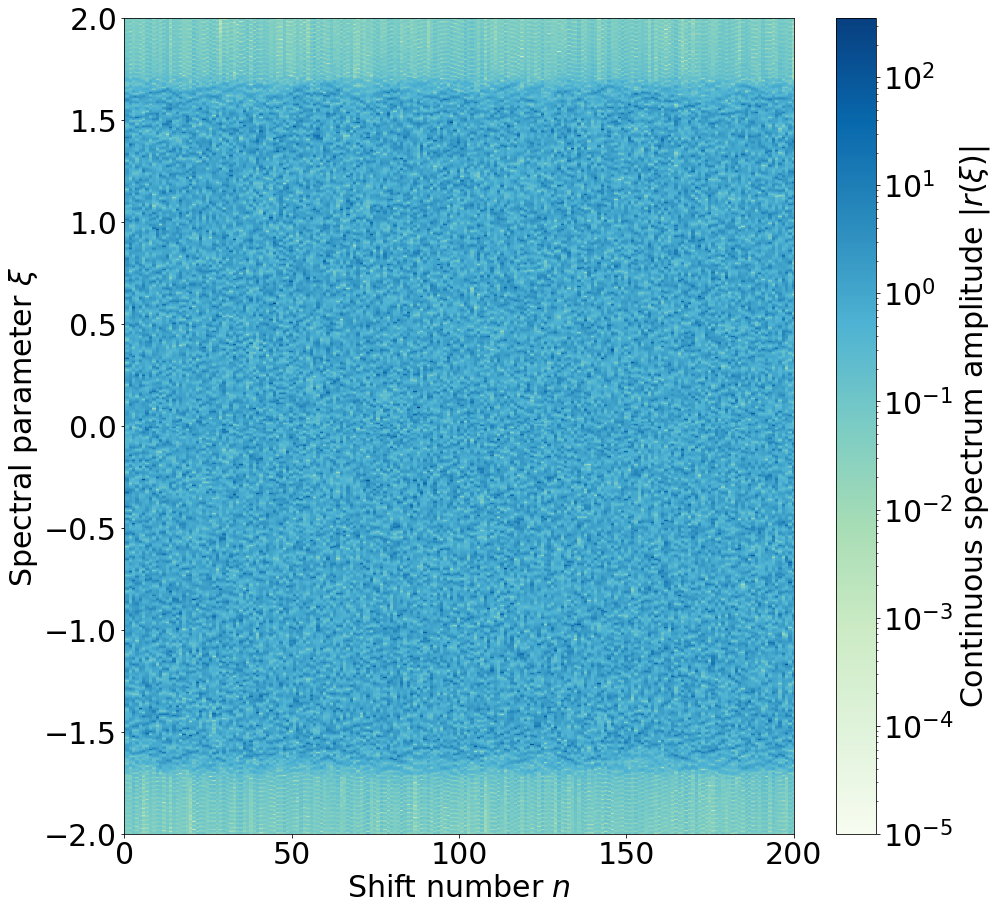

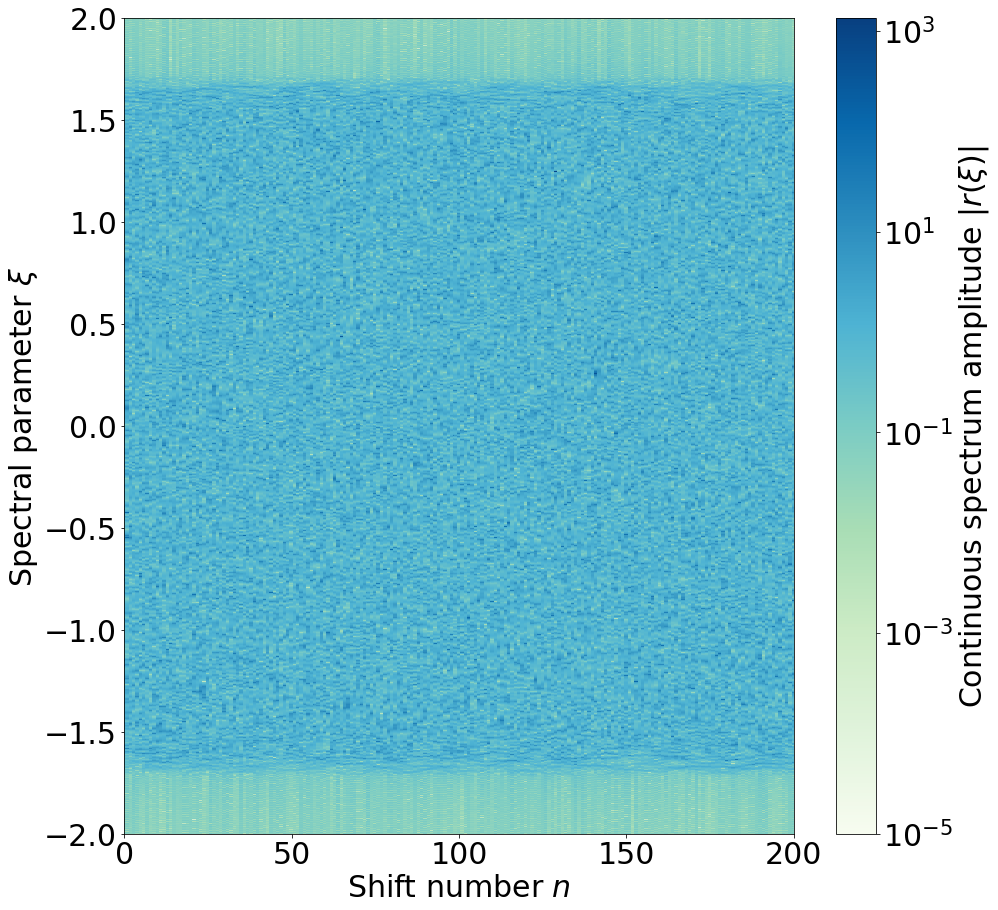

In [41]:
matplotlib.rcParams.update({'font.size': 30})

# def df_to_plotly(df):
#     return {'z': df.values.tolist(),
#             'x': df.columns.tolist(),
#             'y': df.index.tolist()}

# def fmt(x, pos):
#     a, b = '{:.2e}'.format(x).split('e')
#     b = int(b)
#     return r'${} \times 10^{{{}}}$'.format(a, b)
#
# cbar = plt.colorbar(contour, format=ticker.FuncFormatter(fmt))
# cbar.set_label('your label here')

# draw spectrogram

for plot_num_symb_d in [0, 64, 128]:
# for plot_num_symb_d in [0]:

    if plot_num_symb_d == 0:
        xi = xi_0
        y = y_0
        x = x_0
        z = z_0
    elif plot_num_symb_d == 64:
        xi = xi_64
        y = y_64
        x = x_64
        z = z_64
    elif plot_num_symb_d == 128:
        xi = xi_128
        y = y_128
        x = x_128
        z = z_128

    z_max = np.max(z)

    fig, axs = plt.subplots(1, 1, figsize=(15, 15))
    c = axs.pcolor(x, y, z,
                   norm=colors.LogNorm(vmin=0.00001, vmax=z_max),
                   cmap='GnBu', shading='auto', rasterized=True)

    cbar = plt.colorbar(c, ax=axs)
    cbar.set_label(r'Continuous spectrum amplitude $|r(\xi)|$')

    axs.set_ylim(-2, 2)
    axs.set_xlim(0, 200)
    axs.set_ylabel(r'Spectral parameter $\xi$')
    axs.set_xlabel(r'Shift number $n$')

    plt.show()
    # fig.savefig('images_signal_process/spectrogram_r_ts_32_' + 'td_' + str(plot_num_symb_d) + '.png', format='png', bbox_inches='tight')
    fig.savefig('images_signal_process/spectrogram_real_r_ts_32_' + str(current_dbm) + 'dbm_' + 'td_' + str(plot_num_symb_d) + '.png', format='png', bbox_inches='tight')


### Plot signal



In [ ]:
matplotlib.rcParams.update({'font.size': 30})




### Plot discrete spectrum

In [11]:

def complete_2d_discrete(xi, xi_energy, df_plot, proc_steps, num_symb_d):

    for i_proc in range(proc_steps):
    # for d in df_plot[(df_plot.num_symb_d == 0)]['res']:

        # 4 * np.sum(np.imag(res['bound_states']))

        temp = df_plot[(df_plot.num_symb_d == num_symb_d)]['res'].to_list()[i_proc]['bound_states']

        # temp = d.get('bound_states')
        if len(temp) == 0:
            continue
        else:
            # here I have to go through xi_0 and find energy in each bin

            # print(temp)
            temp_sorted = np.sort_complex(temp)
            # print(temp_sorted)

            xi_length = xi[-1] - xi[0]
            d_xi = xi_length / (len(xi) - 1)
            # print(xi[0], xi[1], xi[0] + d_xi)

            for d_value in temp_sorted:
                # find where put 4 Im(d_value) in xi array

                d_value_r = np.real(d_value)
                d_value_i = np.imag(d_value)
                if d_value_r < xi[0]:
                    print('Error')

                xi_pos = int(np.floor((d_value_r - xi[0]) / d_xi))
                # print(xi_pos, d_value_r, xi_0[xi_pos], xi_0[xi_pos + 1])

                xi_energy[i_proc][xi_pos] += 4.0 * d_value_i



In [42]:

xi_0 = df_plot[(df_plot.num_symb_d == 0)]['xi'].to_list()[0]
xi_64 = df_plot[(df_plot.num_symb_d == 64.0)]['xi'].to_list()[0]
xi_128 = df_plot[(df_plot.num_symb_d == 128.0)]['xi'].to_list()[0]
n_xi_0 = len(xi_0)
n_xi_64 = len(xi_64)
n_xi_128 = len(xi_128)

proc_steps_0 = int(df_plot[(df_plot.num_symb_d == 0)]['proc_steps'].to_list()[0])
proc_steps_64 = int(df_plot[(df_plot.num_symb_d == 64.0)]['proc_steps'].to_list()[0])
proc_steps_128 = int(df_plot[(df_plot.num_symb_d == 128.0)]['proc_steps'].to_list()[0])

y_0, x_0 = np.meshgrid(xi_0, np.array(range(proc_steps_0)))
y_64, x_64 = np.meshgrid(xi_64, np.array(range(proc_steps_64)))
y_128, x_128 = np.meshgrid(xi_128, np.array(range(proc_steps_128)))

xi_energy_0 = np.zeros((proc_steps_0, n_xi_0))
xi_energy_64 = np.zeros((proc_steps_64, n_xi_64))
xi_energy_128 = np.zeros((proc_steps_128, n_xi_128))


complete_2d_discrete(xi_0, xi_energy_0, df_plot, proc_steps_0, 0)
complete_2d_discrete(xi_64, xi_energy_64, df_plot, proc_steps_64, 64)
complete_2d_discrete(xi_128, xi_energy_128, df_plot, proc_steps_128, 128)



        # xi_n_0.append(np.array(temp))
# xi_n_0 = np.array(xi_n_0)
# xi_n_0 = np.array([d.get('bound_states') for d in df_plot[(df_plot.num_symb_d == 0)]['res']])

# xi_n_0_real = np.real(xi_n_0)
# xi_n_0_imag = np.imag(xi_n_0)
#
# y_0, x_0 = np.meshgrid(xi_0, np.array(range(proc_steps)))
z_0 = xi_energy_0
z_64 = xi_energy_64
z_128 = xi_energy_128
#
# print(xi_n_0)
#

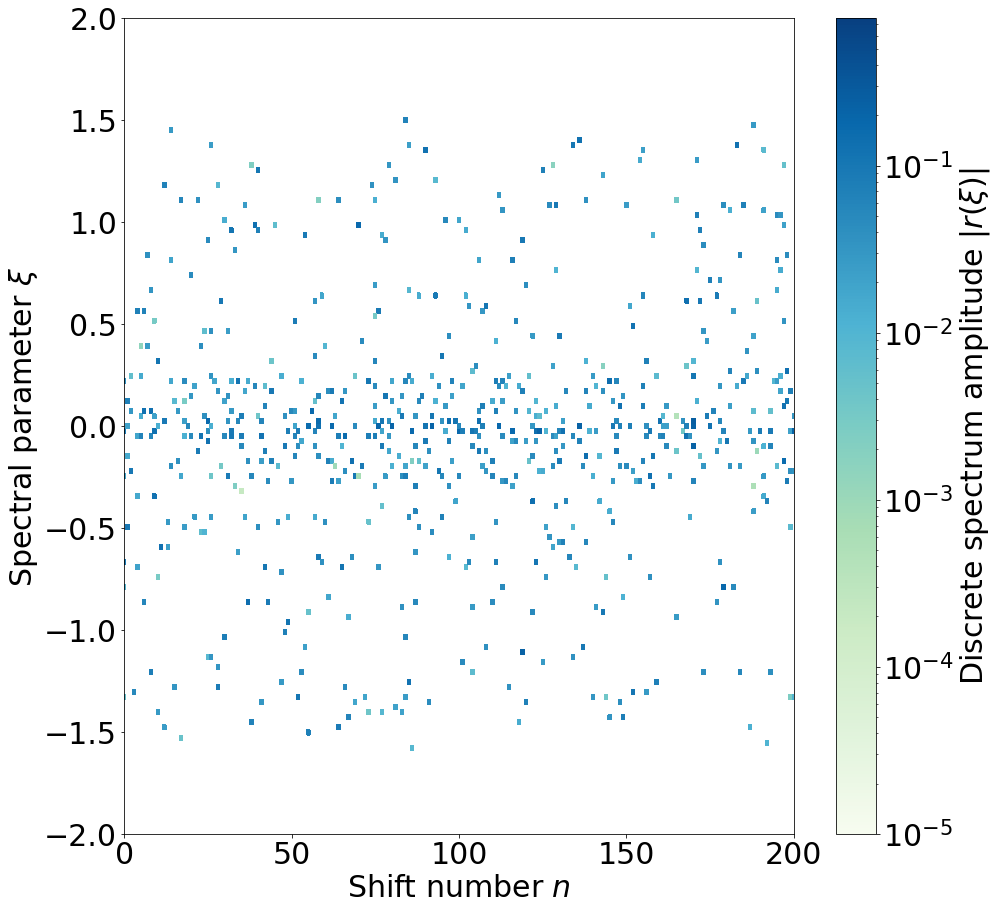

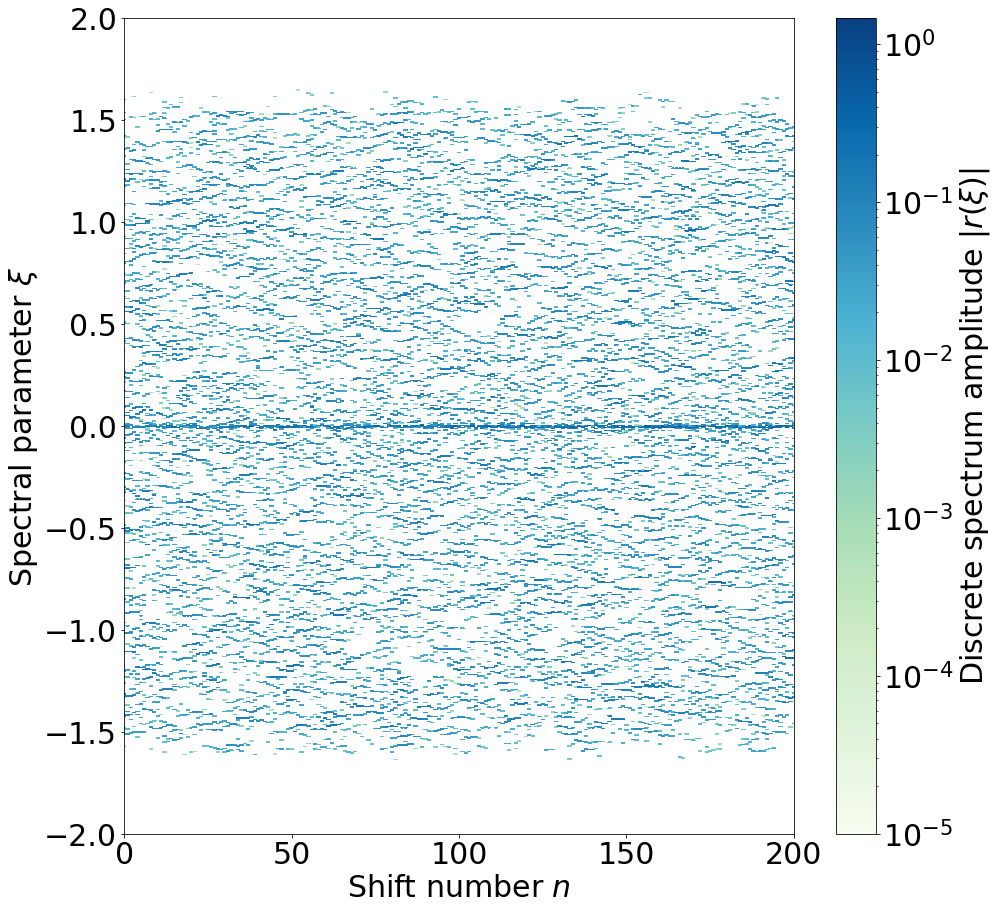

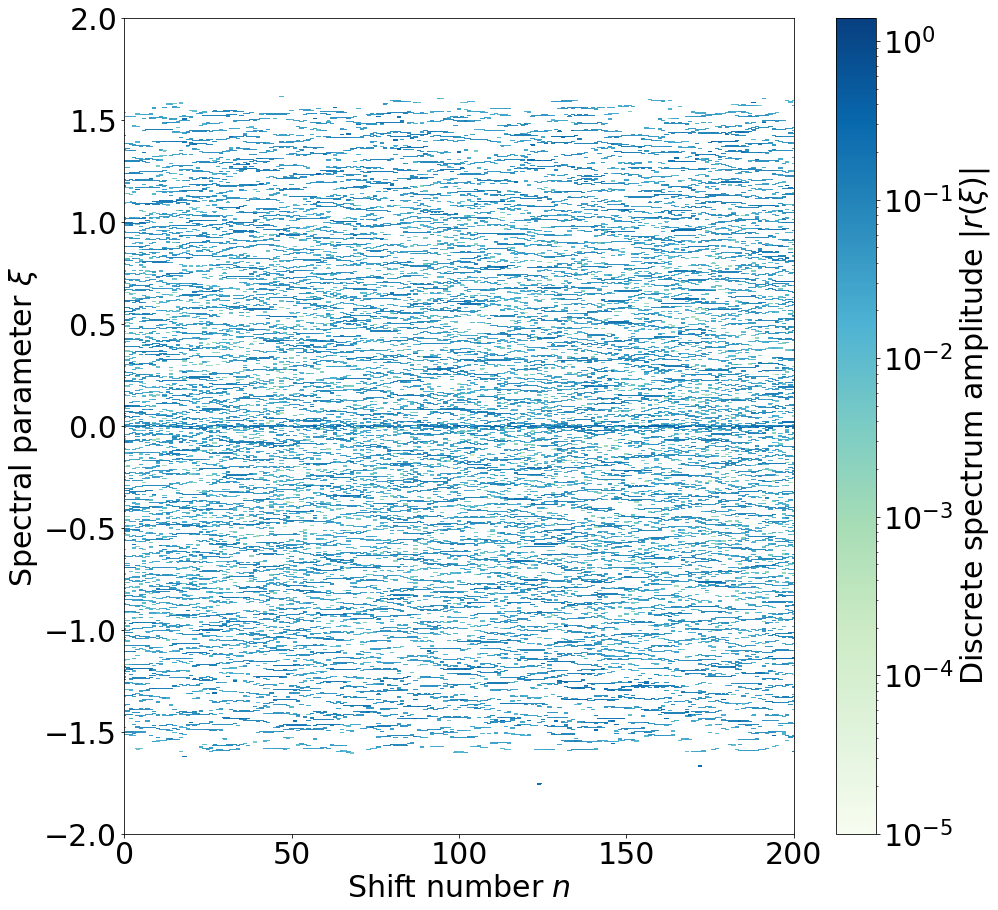

In [43]:
matplotlib.rcParams.update({'font.size': 30})

for plot_num_symb_d in [0, 64, 128]:
# for plot_num_symb_d in [0]:

    if plot_num_symb_d == 0:
        xi = xi_0
        y = y_0
        x = x_0
        z = z_0
    elif plot_num_symb_d == 64:
        xi = xi_64
        y = y_64
        x = x_64
        z = z_64
    elif plot_num_symb_d == 128:
        xi = xi_128
        y = y_128
        x = x_128
        z = z_128

    z_max = np.max(z)

    fig, axs = plt.subplots(1, 1, figsize=(15, 15))
    c = axs.pcolor(x, y, z,
                   norm=colors.LogNorm(vmin=0.00001, vmax=z_max),
                   cmap='GnBu', shading='auto', rasterized=True)

    cbar = plt.colorbar(c, ax=axs)
    cbar.set_label(r'Discrete spectrum amplitude $|r(\xi)|$')

    axs.set_ylim(-2, 2)
    axs.set_xlim(0, 200)
    axs.set_ylabel(r'Spectral parameter $\xi$')
    axs.set_xlabel(r'Shift number $n$')

    plt.show()
    # fig.savefig('images_signal_process/spectrogram_discrete_ts_32_' + 'td_' + str(plot_num_symb_d) + '.png', format='png', bbox_inches='tight')
    fig.savefig('images_signal_process/spectrogram_real_discrete_ts_32_' + str(current_dbm) + 'dbm_' + 'td_' + str(plot_num_symb_d) + '.png', format='png', bbox_inches='tight')





## Check regions where NFT is working

In [5]:
df_region = pd.DataFrame()


In [4]:
# create signal

mod_type = "16qam"
n_car = 1
t_symb = 1.0
n_symb = 4
dt = t_symb / n_symb
num_symbols = 2 ** 12
n_lateral = 32 * n_symb
# p_ave = 0.74
# p_ave = 0.05
roll_off = 0.01

num_symb_skip_shift = 32

for p_dbm in [-20, -10] + [-10 + i_temp * (0 - (-10)) / 20 for i_temp in range(1, 20)] + [0, 1, 2, 3, 5]:
    p_ave = round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6)

    data = sg.gen_wdm_bit_sequence(num_symbols, mod_type, n_car)
    points = sg.get_constellation_point(data, mod_type)
    signal = sg.get_wdm_signal(data, t_symb=t_symb, n_symb=n_symb,
                            func=sg.srrcos, func_args=[t_symb, roll_off],
                            n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
    signal = sg.set_average_power(signal, dt, p_ave, n_symb * (num_symbols // 2 - 1))
    # print(len(signal), sg.next_power_of_2(len(signal)))
    # signal = sg.add_lateral(signal, 2**13 - len(signal) // 2)
    n_add = sg.next_power_of_2(len(signal)) - len(signal) // 2
    signal = sg.add_lateral(signal, n_add)

    # signal = sg.add_lateral(signal, 2**10)

    np_signal = len(signal)
    t_vector = np.array([(i - np_signal / 2) * dt for i in range(np_signal)])

    for num_symb_proc in [1, 4, 16, 32, 64, 128]:
        for num_symb_d_max in [128]:

            step = num_symb_proc
            proc_steps = (num_symbols - 2 * num_symb_skip_shift - 2 * num_symb_d_max) // step

            for proc_iter in range(proc_steps):
            # for proc_iter in [temp_r[0], temp_r[1]]:

                # to do three intervals I have to take
                for num_symb_d in [0, num_symb_d_max // 2, num_symb_d_max]:
                # for num_symb_d in [0]:
                    # num_symb_d = 256
                    num_symb_total = 2 * num_symb_d + num_symb_proc

                    num_symb_skip_base = num_symb_d + num_symb_skip_shift # desire skip to the proc interval. Have to be bigger that num_symb_d
                    num_symb_skip = num_symb_skip_base - num_symb_d + proc_iter * step

                    signal_cut, t_cut = get_sub_signal(signal, n_symb, t_symb, num_symb_total, num_symb_skip, n_add + n_lateral)

                    # ft_spectrum = fftshift(fft(signal_cut))
                    # ft_w = np.array([(i - len(signal_cut) / 2) * (2. * np.pi / len(signal_cut)) for i in range(len(signal_cut))])

                    signal_cut, t_cut = add_lateral_to_signal(signal_cut, slope, t_cut)
                    # print(len(signal_cut))

                    xi, res, time = do_nft(signal_cut, t_cut)
                    # print("n sol", num_symb_d, len(res['bound_states']))
                    dxi = xi[1] - xi[0]

                    l1_norm = sg.get_l1(signal_cut, dt)
                    l2_norm = sg.get_energy(signal_cut, dt)
                    e_discrete = 4 * np.sum(np.imag(res['bound_states']))
                    e_cont = -1. / np.pi * np.sum(np.log(np.power(np.absolute(res['cont_a']), 2))) * dxi



                    # result_dict = {"signal": signal_cut, "t": t_cut, "res": res, "xi": xi,
                    #                "l1_norm": l1_norm, "l2_norm": l2_norm,
                    #                "e_discrete": e_discrete, "e_cont": e_cont,
                    #                "e_tot": e_discrete + e_cont,
                    #                "e_lost": np.absolute(e_discrete + e_cont - l2_norm),
                    #                "e_lost_rel": np.absolute(e_discrete + e_cont - l2_norm) / l2_norm,
                    #                "time": time,
                    #                'proc_steps': proc_steps,
                    #                "proc_iter": proc_iter,
                    #                'num_symbols': num_symbols,
                    #                'n_symb': n_symb,
                    #                't_symb': t_symb,
                    #                'n_lateral': n_lateral,
                    #                'p_ave': p_ave,
                    #                'roll_off': roll_off,
                    #                'mod_type': mod_type,
                    #                'n_car': n_car,
                    #                'num_symb_d': num_symb_d,
                    #                'num_symb_skip_base': num_symb_skip_base,
                    #                'num_symb_skip': num_symb_skip,
                    #                'num_symb_d_max': num_symb_d_max,
                    #                'num_symb_proc': num_symb_proc,
                    #                'num_symb_skip_shift': num_symb_skip_shift,
                    #                'step': step}

                    result_dict = {
                        # "signal": signal_cut, "t": t_cut, "res": res, "xi": xi,
                                   "l1_norm": l1_norm, "l2_norm": l2_norm,
                                   "e_discrete": e_discrete, "e_cont": e_cont,
                                   "e_tot": e_discrete + e_cont,
                                   "e_lost": np.absolute(e_discrete + e_cont - l2_norm),
                                   "e_lost_rel": np.absolute(e_discrete + e_cont - l2_norm) / l2_norm,
                                   # "time": time,
                                   # 'proc_steps': proc_steps,
                                   # "proc_iter": proc_iter,
                                   'num_symbols': num_symbols,
                                   # 'n_symb': n_symb,
                                   # 't_symb': t_symb,
                                   # 'n_lateral': n_lateral,
                                   'p_ave': p_ave,
                                   # 'roll_off': roll_off,
                                   # 'mod_type': mod_type,
                                   # 'n_car': n_car,
                                   'num_symb_d': num_symb_d,
                                   # 'num_symb_skip_base': num_symb_skip_base,
                                   # 'num_symb_skip': num_symb_skip,
                                   # 'num_symb_d_max': num_symb_d_max,
                                   'num_symb_proc': num_symb_proc,
                                   # 'num_symb_skip_shift': num_symb_skip_shift,
                                   'step': step}

                    # print(np.absolute(e_discrete + e_cont - l2_norm), l2_norm, np.absolute(e_discrete + e_cont - l2_norm) / l2_norm)

                    df_region = df_region.append(result_dict, ignore_index=True)

df_region.to_pickle("nft_continuous_signal_scan_region.pkl")


NameError: name 'df_region' is not defined

## General function to process signals

In [92]:
def get_spectrograms(signal, n_symb, t_symb, num_symbols, ns_proc, step, ns_skip, shift, file_name):

    dt = t_symb / n_symb
    num_symb_proc = ns_proc # number of processed symbols (main interval)
    num_symb_skip_shift = ns_skip # some initial shift from left side
    # step = num_symb_proc # step size

    # maximum dispersion distance in t_s
    num_symb_d_max = 128

    # number of processing steps
    proc_steps = (num_symbols - 2 * num_symb_skip_shift - 2 * num_symb_d_max) // step
    if proc_steps > 300:
        proc_steps = 300
    # temp_r = [i for i in range(proc_steps)]

    df = pd.DataFrame()

    for proc_iter in range(proc_steps):
    # for proc_iter in [temp_r[0], temp_r[1]]:

        # to do three intervals I have to take
        for num_symb_d in [0, num_symb_d_max // 2, num_symb_d_max]:

            num_symb_total = 2 * num_symb_d + num_symb_proc
            num_symb_skip_base = num_symb_d + num_symb_skip_shift # desire skip to the proc interval. Have to be bigger that num_symb_d
            num_symb_skip = num_symb_skip_base - num_symb_d + proc_iter * step

            signal_cut, t_cut = get_sub_signal(signal, n_symb, t_symb, num_symb_total, num_symb_skip, shift)

            ft_spectrum = fftshift(fft(signal_cut))
            ft_w = np.array([(i - len(signal_cut) / 2) * (2. * np.pi / len(signal_cut)) for i in range(len(signal_cut))])

            signal_cut, t_cut = add_lateral_to_signal(signal_cut, slope, t_cut)
            # print(len(signal_cut))

            xi, res, time = do_nft(signal_cut, t_cut)
            # print("n sol", num_symb_d, len(res['bound_states']))
            dxi = xi[1] - xi[0]

            l1_norm = sg.get_l1(signal_cut, dt)
            l2_norm = sg.get_energy(signal_cut, dt)
            e_discrete = 4 * np.sum(np.imag(res['bound_states']))
            e_cont = -1. / np.pi * np.sum(np.log(np.power(np.absolute(res['cont_a']), 2))) * dxi



            result_dict = {"signal": signal_cut, "t": t_cut, "res": res, "xi": xi,
                           "l1_norm": l1_norm, "l2_norm": l2_norm,
                           "e_discrete": e_discrete, "e_cont": e_cont,
                           "e_tot": e_discrete + e_cont,
                           "time": time,
                           'proc_steps': proc_steps,
                           "proc_iter": proc_iter,
                           'num_symbols': num_symbols,
                           'n_symb': n_symb,
                           't_symb': t_symb,
                           'num_symb_d': num_symb_d,
                           'num_symb_skip_base': num_symb_skip_base,
                           'num_symb_skip': num_symb_skip,
                           'num_symb_d_max': num_symb_d_max,
                           'num_symb_proc': num_symb_proc,
                           'num_symb_skip_shift': num_symb_skip_shift,
                           'step': step}

            # print(np.absolute(e_discrete + e_cont - l2_norm), l2_norm, np.absolute(e_discrete + e_cont - l2_norm) / l2_norm)

            df = df.append(result_dict, ignore_index=True)

    df.to_pickle(file_name + ".pkl")


## Process files from Pedro

In [ ]:
# Get signal and go to dimensionless form

for p_dbm_temp in range(-10, -3):
    # p_dbm_temp = 3

    mat = scipy.io.loadmat('../data/signal_from_pedro/SSMF_SP_SC_[Train]_resolution_1km_30_X_50_Km_' + str(p_dbm_temp) + '_Pdbm_30_GBd_16_QAM.mat')

    m_dt = mat['delta_t'][0][0]
    sp_symb = mat['sps'][0][0]
    t_dim = m_dt * sp_symb * 10 ** 12
    t_dimless = 1.0
    dt_dimless = t_dimless / sp_symb

    beta2_mat = abs(sg.dispersion_to_beta2(16.8))
    gamma_mat = 1.14 * 10**(-3)

    print(mat['Q2factor'])

    mat_signal = np.reshape(mat['Signal_x_before_fiber'], (1, -1))[0]


    p_dbm_actual = sg.mw_to_dbm(sg.get_average_power(mat_signal, m_dt) * 1000)
    p_nd_temp = sg.mw_to_nd(sg.dbm_to_mw(p_dbm_actual), t_symb=t_symb,
                            beta2=abs(sg.dispersion_to_beta2(16.8)),
                            gamma=1.14 * 10 ** (-3))

    print(p_dbm_actual, p_nd_temp)

    # That is how it should be
    # mat_signal = mat_signal * (np.sqrt(gamma_mat / beta2_mat) * (t_dim / t_dimless))
    # print(sg.mw_to_dbm(sg.nd_to_mw(sg.get_average_power(mat_signal, dt_dimless), t_symb=t_dim, beta2=beta2_mat, gamma=gamma_mat)))
    # That is how i have to do
    mat_signal = sg.set_average_power(mat_signal, dt=dt_dimless, power=p_nd_temp)
    print(sg.mw_to_dbm(sg.nd_to_mw(sg.get_average_power(mat_signal, dt_dimless), t_symb=t_dim, beta2=beta2_mat, gamma=gamma_mat))) # should be equal to p_dbm_temp
    # print(sg.get_average_power(mat_signal, dt_dimless))


    get_spectrograms(mat_signal, sp_symb, t_dimless, num_symbols=2**16, ns_proc=32, step=32, ns_skip=128, shift=0,
                     file_name="nft_real_signal_spectogram_" + str(p_dbm_temp) + "dbm")



[[9.6192064]]
-9.99057551753431 0.005928341801461813
-9.990575517534312


## Some 2d plots


In [88]:
current_dbm = -4

# df_plot = pd.read_pickle("nft_continuous_signal_scan.pkl")
df_plot = pd.read_pickle("nft_real_signal_spectogram_" + str(current_dbm) + "dbm.pkl")


### Plot
I have several variables, for example
```
e_cont, e_discrete, l2_norm, e_tot, proc_iter
```
so I can plot this graphs

In [65]:
print(df_plot[(df_plot.num_symb_d == 64)]['num_symb_proc'])

1      32.0
4      32.0
7      32.0
10     32.0
13     32.0
       ... 
886    32.0
889    32.0
892    32.0
895    32.0
898    32.0
Name: num_symb_proc, Length: 300, dtype: float64


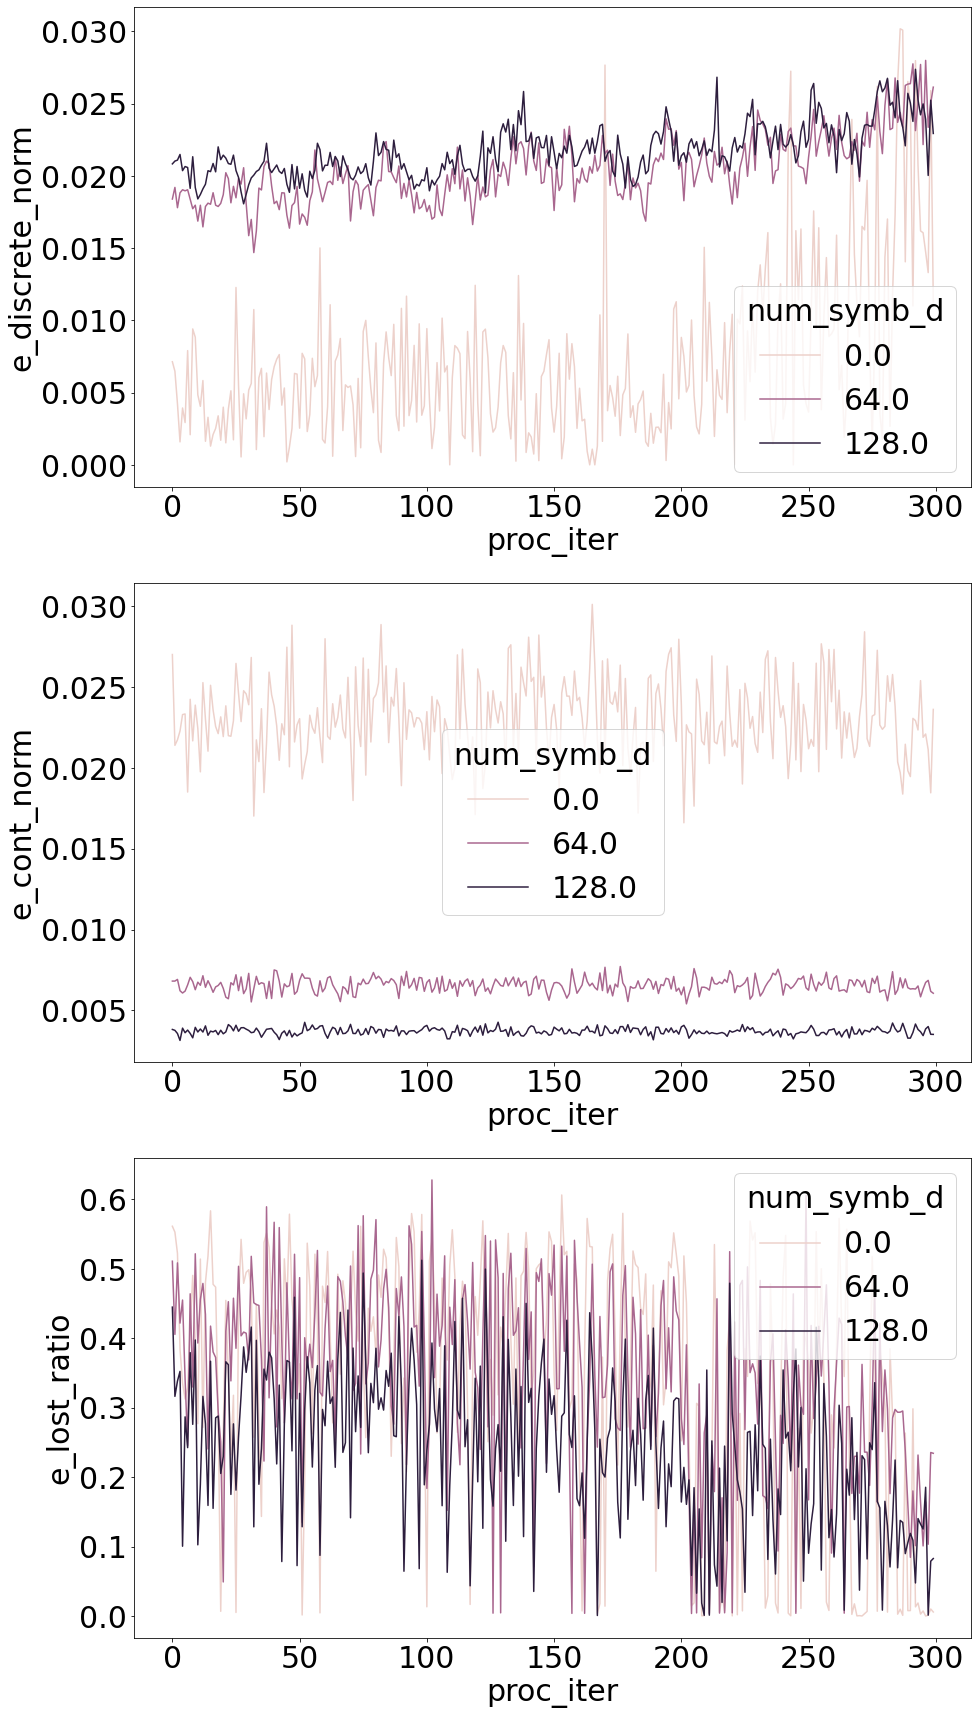

In [89]:
import seaborn as sns

df_temp = df_plot
# print(df_temp)
# df_temp['e_discrete_ratio'] = df_temp['e_discrete'] / (df_temp['l2_norm'])
df_temp['e_discrete_norm'] = df_temp['e_discrete'] / (df_temp['num_symb_proc'] + 2 * df_temp['num_symb_d'])
# df_temp['e_cont_ratio'] = df_temp['e_cont'] / df_temp['l2_norm']
df_temp['e_cont_norm'] = df_temp['e_cont'] / (df_temp['num_symb_proc'] + 2 * df_temp['num_symb_d'])
df_temp['e_tot_norm'] = df_temp['e_tot'] / (df_temp['num_symb_proc'] + 2 * df_temp['num_symb_d'])
df_temp['e_lost_norm'] = abs(df_temp['e_tot'] - df_temp['l2_norm']) / (df_temp['num_symb_proc'] + 2 * df_temp['num_symb_d'])
df_temp['e_lost_ratio'] = abs(df_temp['e_tot'] - df_temp['l2_norm']) / df_temp['l2_norm']

# print(df_temp)

matplotlib.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(3, 1, figsize=(15, 30))

sns.lineplot(ax=axs[0], data=df_temp, x="proc_iter", y="e_discrete_norm", hue="num_symb_d")
sns.lineplot(ax=axs[1], data=df_temp, x="proc_iter", y="e_cont_norm", hue="num_symb_d")
# sns.lineplot(ax=axs[2], data=df_temp, x="proc_iter", y="e_tot_norm", hue="num_symb_d")
sns.lineplot(ax=axs[2], data=df_temp, x="proc_iter", y="e_lost_ratio", hue="num_symb_d")

fig.savefig('images_signal_process/energy_ts_32_' + str(current_dbm) + 'dbm.png', format='png', bbox_inches='tight')

In [ ]:
# print(df_plot['res'][0]['cont_ref'])
# print(df_plot['xi'][0])
# print(xi)

# print(num_symb_d_max // 2)
# print(df_plot[(df_plot.num_symb_d == 128)]['xi'].to_list()[0])
xi_0 = df_plot[(df_plot.num_symb_d == 0)]['xi'].to_list()[0]
xi_64 = df_plot[(df_plot.num_symb_d == 64.0)]['xi'].to_list()[0]
xi_128 = df_plot[(df_plot.num_symb_d == 128.0)]['xi'].to_list()[0]










# Here is backup

In [118]:
print([i for i in  range(-20, -3)])
print("hello")

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4]
hello


In [44]:
signal = signal_cut

In [46]:
start = timer()

z_prop = 0

np_signal = len(signal)
np_spectrum = 2 * np_signal

t_vector = np.array([(i - np_signal / 2) * dt for i in range(np_signal)])

# calculate suitable frequency bonds (xi)
rv, xi_bound = nsev_inverse_xi_wrapper(np_signal, t_vector[0], t_vector[-1], np_spectrum)
xi_vector = xi_bound[0] + np.arange(np_spectrum) * (xi_bound[1] - xi_bound[0]) / (np_spectrum - 1)

res = nsev(signal, t_vector, M=np_spectrum, Xi1=xi_bound[0], Xi2=xi_bound[1], kappa=1)

end = timer()

print('Forward NFT', end - start, 's')

cont_spec = res['cont_ref']
bound_states = res['bound_states']
print(len(bound_states), bound_states)
disc_norm = res['disc_norm']

# bound_states = []
# disc_norm = []

z_prop_nft = -z_prop
cont_spec_prop = cont_spec * np.exp(-2. * 1.0j * z_prop_nft * np.power(np.array(xi_vector), 2))
disc_norm_prop = disc_norm * np.exp(-2. * 1.0j * z_prop_nft * np.power(np.array(bound_states), 2))

start = timer()
res_bprop = nsev_inverse(xi_vector, t_vector, cont_spec_prop, bound_states, disc_norm_prop, cst=0, dst=0)
end = timer()
print('Backward NFT', end - start, 's')

signal_bprop_nft = res_bprop['q']


Forward NFT 0.03542433100028575 s
10 [ 1.41186426+0.04934733j  1.05203641+0.04454495j  0.7686836 +0.08745693j
  0.52711004+0.01873315j  0.23699937+0.03243249j -0.16736409+0.11283166j
 -0.2955742 +0.02780487j -0.47025284+0.11827919j -0.54514021+0.02350112j
 -1.18893127+0.07997855j]
Backward NFT 0.008615208999799506 s


In [24]:
print(len(bound_states))
print(res_bprop)
# print(signal_bprop_nft)
print(np.sum(np.absolute(signal_bprop_nft - signal)))


63
{'return_value': 0, 'q': array([ 0.00036583+0.00124231j,  0.00040395+0.00119607j,
        0.00043748+0.00114781j, ..., -0.00046939-0.00190861j,
       -0.00056712-0.00186891j, -0.00066095-0.0018218j ]), 'options': "'discretization' : 4, 'contspec_type' : 0, 'contspec_inversion_method' : 0, 'discspec_type' : 0, 'max_iter' : 100, 'oversampling_factor' : 8"}
13.849158495486208


In [4]:
def get_process_interval(signal, n_symb, t_proc, skip=0):

    end_point = int(t_proc * n_symb)
    print(end_point)
    return signal[skip:skip + end_point]

t_proc = 64 * t_symb # 64 symbols to process
num_symb_skip = 32
signal_cut = get_process_interval(signal, n_symb, t_proc, skip=n_add + n_lateral + num_symb_skip * n_symb)
t_cut = get_process_interval(t_vector, n_symb, t_proc, skip=n_add + n_lateral + num_symb_skip * n_symb)

print(len(signal_cut), len(t_cut))
print(len(signal), len(t_vector))

def slope(x):
    if np.absolute(x) > 0:
        return np.exp(-np.power(x, 2))
    else:
        return 0.0

def slope_t(t):
    return t

n_add_cut = sg.next_power_of_2(len(signal_cut)) - len(signal_cut) // 2
signal_cut = sg.add_lateral_function(signal_cut, slope, dt, n = n_add_cut)

# t_cut_add = np.array([(i - len(signal_cut) / 2) * dt for i in range(len(signal_cut))])
# t_cut_add = sg.add_lateral_function(t_cut, slope_t, dt, n = n_add_cut)
t_add_temp = np.array([i * dt for i in range(n_add_cut)])
t_cut_add = np.concatenate((t_add_temp - t_add_temp[-1] + t_cut[0], t_cut, t_add_temp + t_cut[-1]), axis=None)


256
256
256 256
4096 4096


<ipython-input-5-fd6427b1f545>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


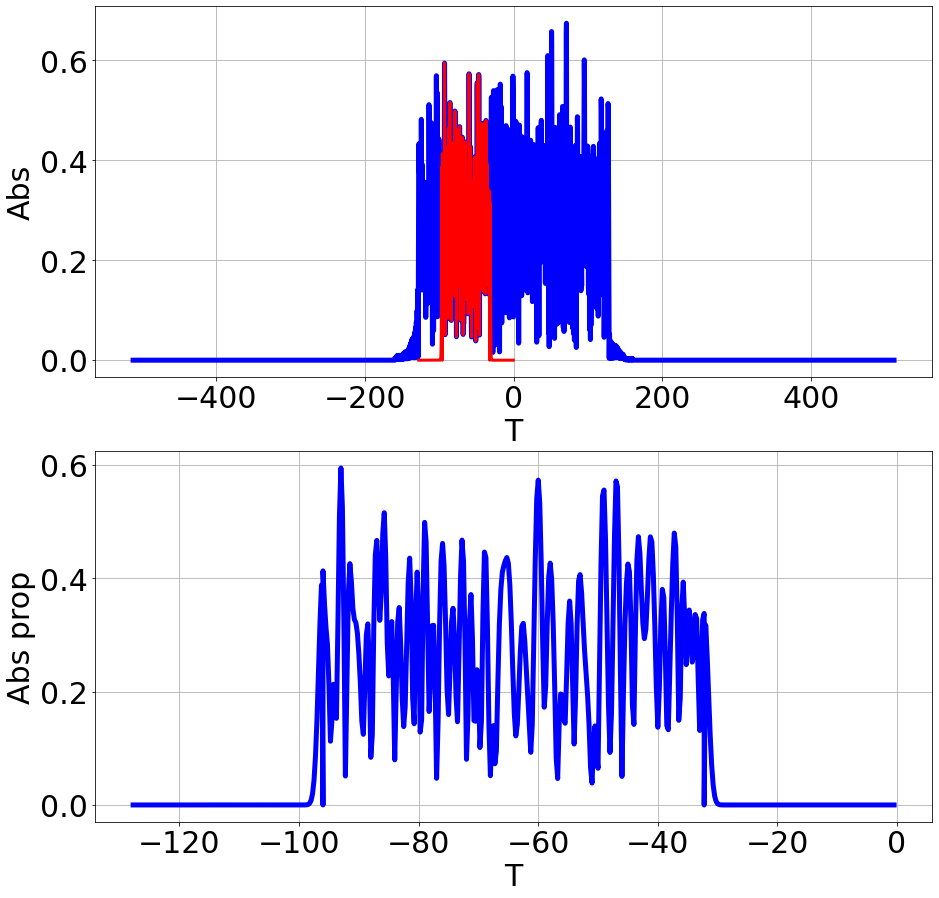

In [5]:
# draw signal and processing interval

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(t_vector, np.absolute(signal),
            color='blue', linewidth=5.0)
axs[0].plot(t_cut_add, np.absolute(signal_cut),
            color='red', linewidth=3.0)
# axs[0].set_xlim(-30, 30)
axs[0].set_xlabel('T')
axs[0].set_ylabel('Abs')
axs[0].grid(True)

axs[1].plot(t_cut_add, np.absolute(signal_cut),
            color='blue', linewidth=5.0)
# axs[1].plot(t_vector, np.absolute(signal) - np.absolute(signal_bprop_nft),
#             color='red', linewidth=3.0)
# axs[1].set_xlim(-20, 20)
axs[1].set_xlabel('T')
axs[1].set_ylabel('Abs prop')
# axs[1].set_yscale('log')
axs[1].grid(True)

fig.show()


In [7]:
# First we process the biggest interval

np_signal = len(signal)
np_spectrum = 2 * np_signal

t_vector = np.array([(i - np_signal / 2) * dt for i in range(np_signal)])

# calculate suitable frequency bonds (xi)
rv, xi_bound = nsev_inverse_xi_wrapper(np_signal, t_vector[0], t_vector[-1], np_spectrum)
xi_vector = xi_bound[0] + np.arange(np_spectrum) * (xi_bound[1] - xi_bound[0]) / (np_spectrum - 1)

start = timer()
res = nsev(signal, t_vector, M=np_spectrum, Xi1=xi_bound[0], Xi2=xi_bound[1], kappa=1)
end = timer()
print('Forward NFT', end - start, 's')

cont_spec = res['cont_ref']
bound_states = res['bound_states']
# print(len(bound_states), bound_states)
disc_norm = res['disc_norm']

# bound_states = []
# disc_norm = []

z_prop_nft = -z_prop
cont_spec_prop = cont_spec * np.exp(-2. * 1.0j * z_prop_nft * np.power(np.array(xi_vector), 2))
disc_norm_prop = disc_norm * np.exp(-2. * 1.0j * z_prop_nft * np.power(np.array(bound_states), 2))

start = timer()
res_bprop = nsev_inverse(xi_vector, t_vector, cont_spec_prop, bound_states, disc_norm_prop, cst=0, dst=0)
end = timer()
print('Backward NFT', end - start, 's')

signal_bprop_nft = res_bprop['q']

# Then we process the next interval

start = timer()
res_cut = nsev(signal_cut, t_cut_add, M=np_spectrum, Xi1=xi_bound[0], Xi2=xi_bound[1], kappa=1)
end = timer()
print('Forward NFT', end - start, 's')

cont_spec_cut = res['cont_ref']
bound_states_cut = res['bound_states']
disc_norm_cut = res['disc_norm']

z_prop_nft = -z_prop
cont_spec_prop = cont_spec * np.exp(-2. * 1.0j * z_prop_nft * np.power(np.array(xi_vector), 2))
disc_norm_prop = disc_norm * np.exp(-2. * 1.0j * z_prop_nft * np.power(np.array(bound_states), 2))

start = timer()
res_bprop_cut = nsev_inverse(xi_vector, t_vector, cont_spec_prop, bound_states, disc_norm_prop, cst=0, dst=0)
end = timer()
print('Backward NFT', end - start, 's')

signal_bprop_nft_cut = res_bprop_cut['q']

Forward NFT 2.1118501729999934 s
Backward NFT 0.6925398619999896 s
Forward NFT 0.09600687900001503 s
Backward NFT 0.5918820679999612 s


In [158]:
result_bi = nft.do_bi_direct(signal_cut, t_cut_add, bound_states_cut[0])
print(result_bi)
print(disc_norm_cut[0])

(-0.025335049518394808-0.04815393801049403j)
(0.9037901437839051-0.07089594837275048j)


<ipython-input-8-270fe77d98e7>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


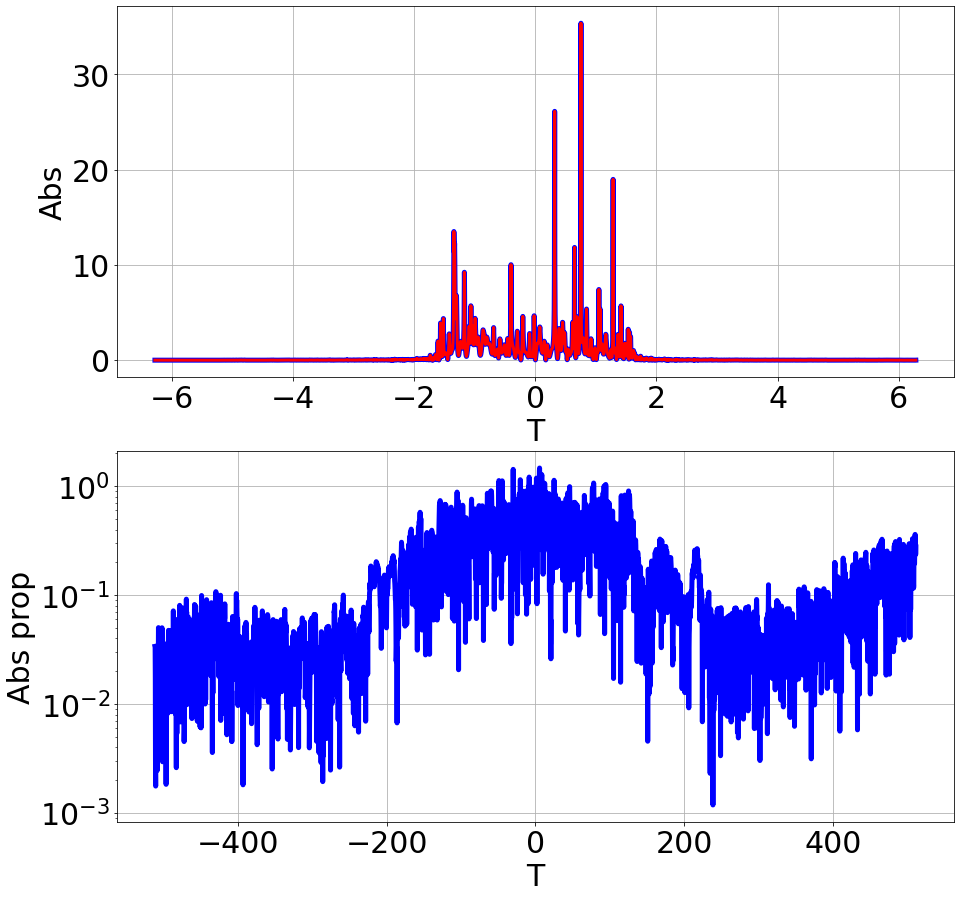

In [8]:
# draw spectrum nft

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(xi_vector, np.absolute(cont_spec),
            color='blue', linewidth=5.0)
axs[0].plot(xi_vector, np.absolute(cont_spec_cut),
            color='red', linewidth=3.0)
# axs[0].set_xlim(-30, 30)
axs[0].set_xlabel('T')
axs[0].set_ylabel('Abs')
axs[0].grid(True)

axs[1].plot(t_vector, np.absolute(signal_bprop_nft - signal),
            color='blue', linewidth=5.0)
# axs[1].plot(t_vector, np.absolute(signal) - np.absolute(signal_bprop_nft),
#             color='red', linewidth=3.0)
# axs[1].set_xlim(-20, 20)
axs[1].set_xlabel('T')
axs[1].set_ylabel('Abs prop')
axs[1].set_yscale('log')
axs[1].grid(True)

fig.show()

<ipython-input-47-20bfb3b093c8>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-47-20bfb3b093c8>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


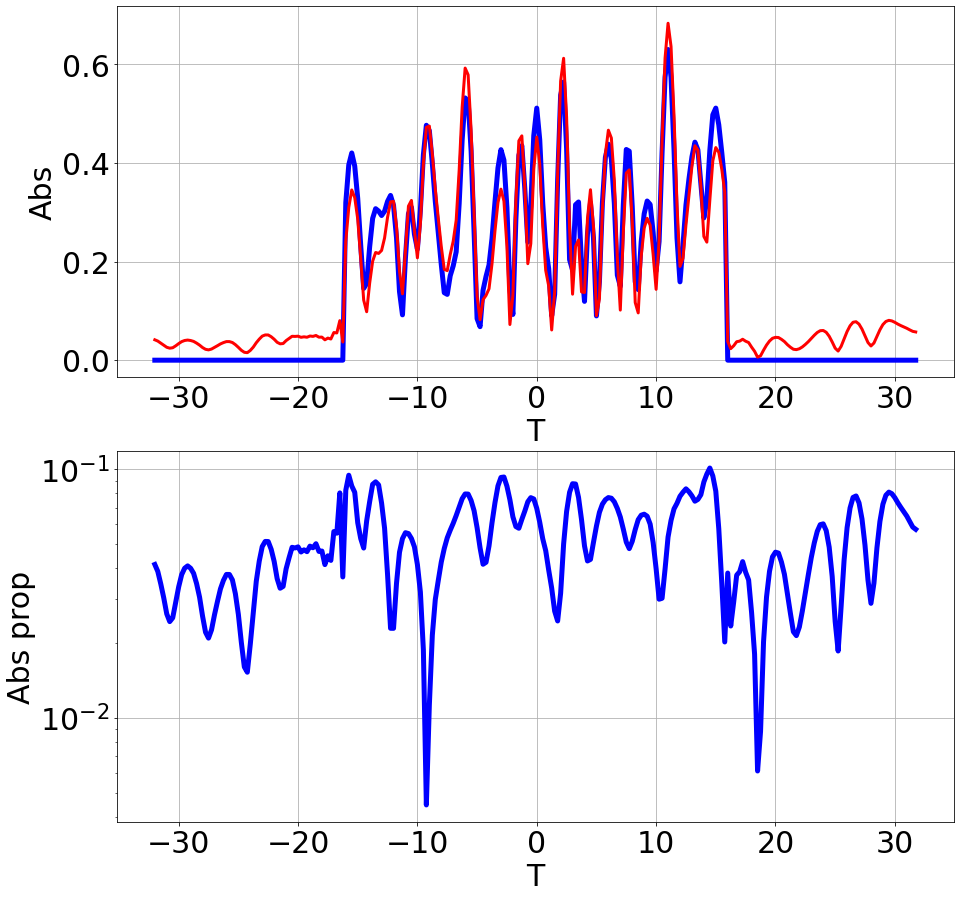

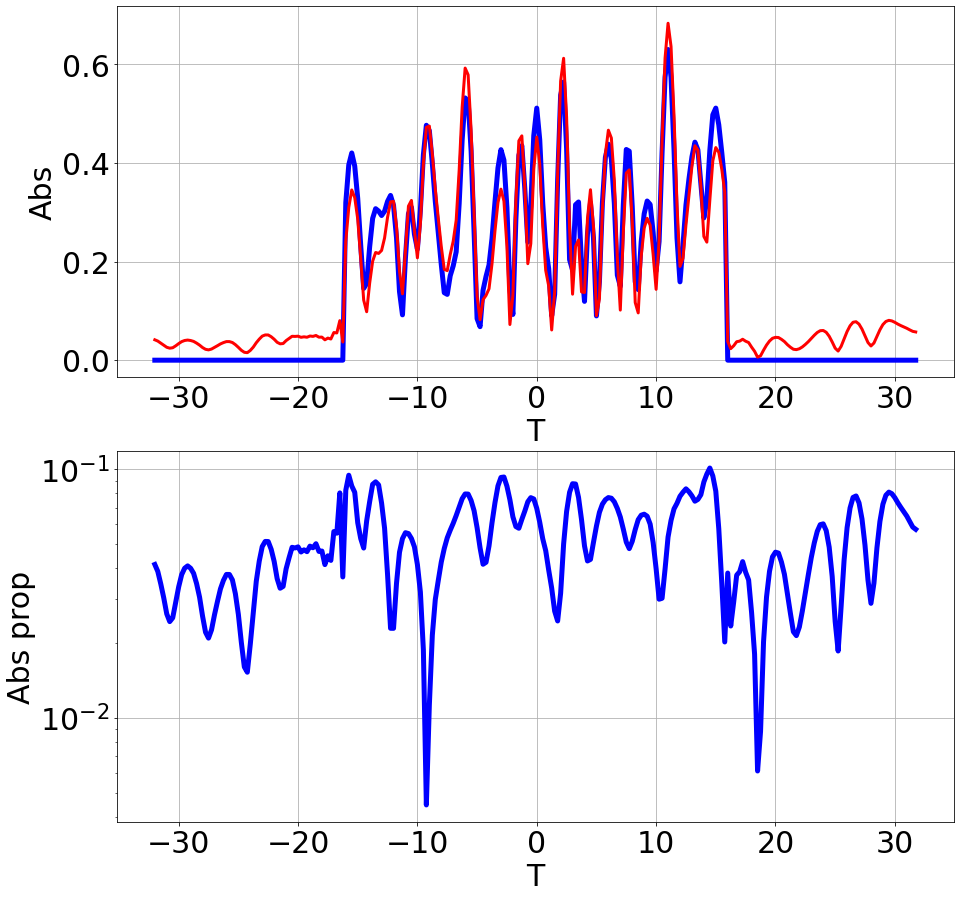

In [47]:
# draw signal nft

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(t_vector, np.absolute(signal),
            color='blue', linewidth=5.0)
axs[0].plot(t_vector, np.absolute(signal_bprop_nft),
            color='red', linewidth=3.0)
# axs[0].set_xlim(-30, 30)
axs[0].set_xlabel('T')
axs[0].set_ylabel('Abs')
axs[0].grid(True)

axs[1].plot(t_vector, np.absolute(signal_bprop_nft - signal),
            color='blue', linewidth=5.0)
# axs[1].plot(t_vector, np.absolute(signal) - np.absolute(signal_bprop_nft),
#             color='red', linewidth=3.0)
# axs[1].set_xlim(-20, 20)
axs[1].set_xlabel('T')
axs[1].set_ylabel('Abs prop')
axs[1].set_yscale('log')
axs[1].grid(True)

fig.show()


# draw cont and discr nft

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(t_vector, np.absolute(signal),
            color='blue', linewidth=5.0)
axs[0].plot(t_vector, np.absolute(signal_bprop_nft),
            color='red', linewidth=3.0)
# axs[0].set_xlim(-30, 30)
axs[0].set_xlabel('T')
axs[0].set_ylabel('Abs')
axs[0].grid(True)

axs[1].plot(t_vector, np.absolute(signal_bprop_nft - signal),
            color='blue', linewidth=5.0)
# axs[1].plot(t_vector, np.absolute(signal) - np.absolute(signal_bprop_nft),
#             color='red', linewidth=3.0)
# axs[1].set_xlim(-20, 20)
axs[1].set_xlabel('T')
axs[1].set_ylabel('Abs prop')
axs[1].set_yscale('log')
axs[1].grid(True)

fig.show()


In [150]:
x = np.zeros((5, 2))
x[0] = np.array([1, 4])
print(x[1])

# a = np.array([1, 2])
# b = np.array([[1, 2], [0, 1]])
#
# print(np.matmul(b, a))
#
# a = np.array([1, 2, 3, 4, 5])
# print(a[-5])
#
# np.linalg.norm(a)

[0. 0.]


In [41]:
# test read mat file


mat = scipy.io.loadmat('../data/signal_from_pedro/signal_0dbm.mat')

In [30]:
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'BAUD_RATE', 'BERX', 'DBP', 'DBP_signalsx', 'DBP_signalsy', 'DD', 'DataL', 'Fs', 'Gain', 'L_testt', 'L_testty', 'L_traint', 'L_trainty', 'M', 'N', 'NF', 'NFdb', 'N_channels', 'No', 'P1txFiltSignal', 'P1txFiltSignaly', 'Pdbm', 'Q2factor', 'Q2factory', 'QX', 'R', 'Sca', 'Seed', 'Signal_x_after_fiber', 'Signal_x_before_DBP', 'Signal_x_before_fiber', 'Signal_x_before_fiber_dw', 'Signal_y_after_fiber', 'Signal_y_before_DBP', 'Signal_y_before_fiber', 'Signal_y_before_fiber_dw', 'StPs', 'WDMSpacing', 'X_des', 'X_in', 'X_testt', 'X_testty', 'X_traint', 'X_trainty', 'Y_des', 'Y_in', 'Y_testt', 'Y_testty', 'Y_traint', 'Y_trainty', 'a', 'alpha', 'alphadb', 'b', 'bb', 'ber', 'bery', 'beta_2', 'c', 'd_in', 'd_iny', 'd_out', 'd_outy', 'dataIn', 'dataIny', 'dataMod', 'dataModsav', 'dataModsavy', 'dataMody', 'dataOut', 'dataOutMatrix', 'dataOutMatrixy', 'dataOuty', 'dataSymbolsOut', 'dataSymbolsOut1', 'dataSymbolsOut1y', 'dataSymbolsOuty', 'delta_

In [82]:
print(mat['beta_2'])
print(np.reshape(mat['Signal_x_before_fiber'], (1, -1))[0][-1])
# print(len(np.reshape(mat['Signal_x_before_fiber'], (1, -1))[0]))

print(mat['delta_t'])
print(mat['M'])
print(mat['N'])


m_dt = mat['delta_t'][0][0]
sp_symb = mat['sps'][0][0]
print(m_dt * sp_symb * 10 ** 12)
t_symb = m_dt * sp_symb * 10 ** 12

p_cur_temp = 0
print(sg.dbm_to_mw(p_cur_temp), sg.mw_to_nd(sg.dbm_to_mw(p_cur_temp), t_symb=t_symb, beta2=abs(sg.dispersion_to_beta2(16.8)), gamma=1.14 * 10 ** (-3)))

[[ 0.0000000e+00  0.0000000e+00 -2.1412706e-23]]
(-0.0004724695255730904+0.0007444919434973579j)
[[4.16666667e-12]]
[[16]]
[[262169]]
33.333333333333336
1.0 0.05915490849631442


In [50]:
beta2_mat = abs(sg.dispersion_to_beta2(16.8))
gamma_mat = 1.14 * 10**(-3)
t_dimless = 1.0
t_dim = m_dt * 8 * 10 ** 12
print(t_dim)

test_mat_signal = np.reshape(mat['Signal_x_before_fiber'], (1, -1))[0]
print(np.mean(np.power(np.absolute(test_mat_signal), 2)))
p_ave_mat = sg.get_average_power(test_mat_signal, m_dt)
print(p_ave_mat)

test_mat_signal = test_mat_signal * (np.sqrt(gamma_mat / beta2_mat) * t_dim / t_dimless)
p_ave_mat = sg.get_average_power(test_mat_signal, 1 / 8.)
print(p_ave_mat, sg.mw_to_dbm(sg.nd_to_mw(p_ave_mat, t_symb=t_symb, beta2=beta2_mat, gamma=gamma_mat)))

# print(len(test_mat_signal) / 8)

# print(m_dt)
p_ave_mat = sg.get_average_power(test_mat_signal, 1 / 8.)
print(p_ave_mat)
# p_ave_mat_nd = sg.mw_to_nd(sg.dbm_to_mw(2), t_symb=t_symb, beta2=abs(sg.dispersion_to_beta2(16.8)), gamma=1.14 * 10 ** (-3))
# test_mat_signal = sg.set_average_power(test_mat_signal, 1 / 8., p_ave_mat_nd)
# print(sg.get_average_power(test_mat_signal, 1 / 8.))

33.333333333333336
0.0005022525387441809
0.000502252538744181
2.9710702971453643e-05 -32.990778593386935
2.9710702971453643e-05


In [44]:
for p_dbm_temp in range(-10, -3):
    # p_dbm_temp = -20
    # mat = scipy.io.loadmat('../data/signal_from_pedro/signal_0dbm.mat')
    mat = scipy.io.loadmat('../data/signal_from_pedro/SSMF_SP_SC_[Train]_resolution_1km_30_X_50_Km_' + str(p_dbm_temp) + '_Pdbm_30_GBd_16_QAM.mat')

    # print(mat.keys())
    print(p_dbm_temp, mat['Q2factor'])

    m_dt = mat['delta_t'][0][0]
    sp_symb = mat['sps'][0][0]
    t_dim = m_dt * sp_symb * 10 ** 12
    t_dimless = 1.0
    dt_dimless = t_dimless / sp_symb

    beta2_mat = abs(sg.dispersion_to_beta2(16.8))
    gamma_mat = 1.14 * 10**(-3)

    # mat_signal = np.reshape(mat['Signal_x_before_fiber'], (1, -1))[0]
    # mat_signal = mat_signal * (np.sqrt(gamma_mat / beta2_mat) * t_dim / t_dimless)

-10 [[9.6192064]]
-9 [[9.7298021]]
-8 [[9.76731759]]
-7 [[9.75465983]]
-6 [[9.75465983]]
-5 [[9.75465983]]
-4 [[9.7298021]]


<ipython-input-24-c56ccacc37b0>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


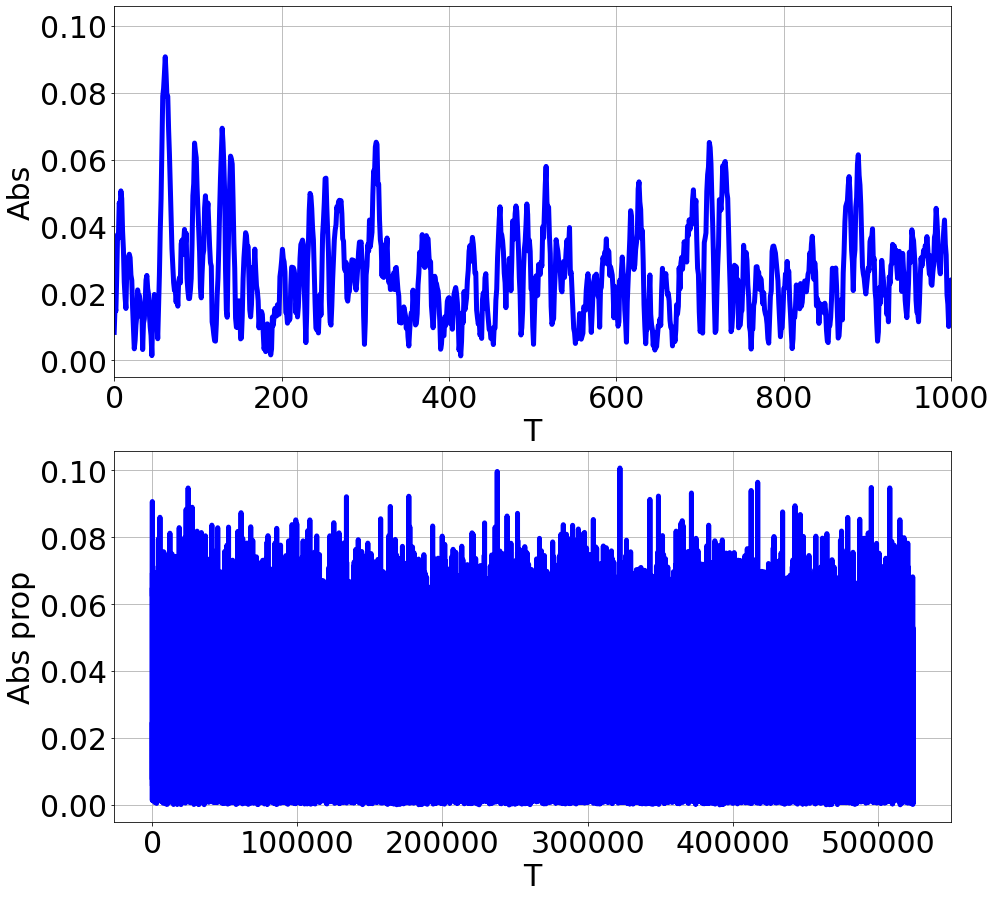

In [24]:
# draw signal and processing interval

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(np.absolute(test_mat_signal),
            color='blue', linewidth=5.0)
# axs[0].plot(t_cut_add, np.absolute(signal_cut),
#             color='red', linewidth=3.0)
axs[0].set_xlim(0, 1000)
axs[0].set_xlabel('T')
axs[0].set_ylabel('Abs')
axs[0].grid(True)

axs[1].plot(np.absolute(test_mat_signal),
            color='blue', linewidth=5.0)
# axs[1].plot(t_vector, np.absolute(signal) - np.absolute(signal_bprop_nft),
#             color='red', linewidth=3.0)
# axs[1].set_xlim(-20, 20)
axs[1].set_xlabel('T')
axs[1].set_ylabel('Abs prop')
# axs[1].set_yscale('log')
axs[1].grid(True)

fig.show()

In [7]:
for p_dbm in [-20, -10] + [-10 + i_temp * (0 - (-10)) / 20 for i_temp in range(1, 20)] + [0, 1, 2, 3, 5]:
    p_ave = round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6)
    print(p_ave)

0.000129
0.001294
0.001452
0.001629
0.001828
0.002051
0.002301
0.002582
0.002897
0.00325
0.003647
0.004092
0.004591
0.005151
0.005779
0.006485
0.007276
0.008164
0.00916
0.010278
0.011532
0.012939
0.016289
0.020506
0.025816
0.040916


In [14]:
for p_dbm in [-20, -10] + [-10 + i_temp * (0 - (-10)) / 20 for i_temp in range(1, 20)] + [0, 1, 2, 3, 5]:
    p_ave = round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=33.33, beta2=abs(sg.dispersion_to_beta2(16.8)), gamma=1.14 * 10 ** (-3)), 6)
    print(p_ave)

print(sg.dispersion_to_beta2(16.8))

0.000591
0.005914
0.006636
0.007446
0.008354
0.009374
0.010517
0.011801
0.01324
0.014856
0.016669
0.018703
0.020985
0.023545
0.026418
0.029642
0.033259
0.037317
0.04187
0.046979
0.052711
0.059143
0.074457
0.093735
0.118006
0.187027
-21.4127060435836


In [99]:
for p_dbm in [-2, -1, 0, 1, 2]:
    p_ave = round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=33.33, beta2=abs(sg.dispersion_to_beta2(16.8)), gamma=1.14 * 10 ** (-3)), 6)
    print(p_ave)

0.037317
0.046979
0.059143
0.074457
0.093735
